In [1]:
import sys
import os
sys.path.append('/Users/syesw/Desktop/JL-Code_Project/Everything-About-Factor-Investing')

In [2]:
from dotenv import load_dotenv
load_dotenv()

rqdata_username = os.getenv('RQDATA_USERNAME')
rqdata_password = os.getenv('RQDATA_PASSWORD')

In [3]:
import rqdatac as rq
import pandas as pd
import numpy as np
from termcolor import colored

In [4]:
from athena import RiceQuantDataHandler, Strategy, Backtest
from athena import sort_the_factor
from athena import run_weekly, run_monthly

In [5]:
# 设置时间范围
start_date = '2020-01-01'
end_date = '2024-01-01'

rqdata = RiceQuantDataHandler(start_date, end_date)
rqdata.auth(rqdata_username,rqdata_password)

asset_list = rqdata.get_index_list('000300.XSHG')

In [6]:
len(asset_list)

300

In [7]:
# 以市值因子为例
# market_cap

In [8]:
factor_data = rqdata.get_factors_from_ricequant(list=asset_list, factors=['market_cap'])

开始获取数据
数据获取完成
开始转换数据结构


In [9]:
backtest_data = rqdata.get_prices_from_ricequant(list=asset_list, fields=['open', 'high', 'low', 'close', 'volume'])

开始获取数据
数据获取完成
开始转换数据结构


In [10]:
#factor_data.to_hdf('factor_data.h5', 'factor_data')
#backtest_data.to_hdf('backtest_data.h5', 'backtest_data')

#factor_data = pd.read_hdf('factor_data.h5', 'factor_data')
#backtest_data = pd.read_hdf('backtest_data.h5', 'backtest_data')

In [11]:
# 假设说要做组合分析：

class SortedFactorInvestStrategy(Strategy):
    def init(self):
        print(colored(f"⚙️ 回测准备: 组{self.group_number}", "blue"))
        self.first_time = True

    @run_monthly
    def next(self, i, record):
        print("----------------------")
        date = self.data.index[i]
        print(colored(str(date) + ': ', "green"))

        print(colored(f"💶 换仓前cash: {self.broker.cash}", "red"))

        current_long_positions, current_short_positions = self.broker.current_position_status()

        if not self.first_time:
            print(colored(f"📨 目前持仓标的: ", "red"))
            print("多头仓位:", current_long_positions)

        day_factors = factor_data.loc[date] # 当天的因子数据
        # 第一步，从高到低排序因子
        sorted_factor_series = sort_the_factor(day_factors, 'market_cap')

        # 第二步，根据十分位数分成十组，并选出第一组和最后一组
        decile = len(sorted_factor_series) // 10
        long_stocks = sorted_factor_series[(self.group_number-1)*decile:self.group_number*decile].index.tolist()
        print(colored(f"📒 选出来的第{self.group_number}组股票: ", "green"))
        print(long_stocks)

        first_time_total_stocks_num = len(long_stocks)
        print(first_time_total_stocks_num)

        # 先换仓
        long_closed = 0
        for stock in current_long_positions:
            # 对于我目前的所有多头仓位,如果不在新的list里，则平仓
            if stock not in long_stocks:
                print(colored(f"📤 关多仓: {stock}", "blue"))
                self.close(symbol=stock, price=record[(stock,'Close')])
                long_closed += 1
        
        if long_closed != 0:
            print(colored(f"💶 关仓后cash: {self.broker.cash}", "red"))
        else:
            print(colored(f"💶 无需关仓cash: {self.broker.cash}", "red"))

        total_closed = long_closed
        if self.first_time == True:
            money_used_for_invest = self.broker.cash / first_time_total_stocks_num - 1000 # 这个是每只股票的投资额
            #re_invest_size = 1 / first_time_total_stocks_num
        elif total_closed == 0: # 没有换仓
            money_used_for_invest = 0
            #re_invest_size = 0
        else:
            money_used_for_invest = self.broker.cash / total_closed - 1000
            #re_invest_size = 1 / total_closed # 关了多少，就重新开多少

        # 买进新的股票
        # 这里的换仓逻辑是，不去干涉已经开仓的股票(不加仓)
        # 对于新开仓的股票，按可分配资金的数量(1/total_closed)来开仓
        # 这样做实现了滚仓的效果
        for stock in long_stocks:
            if long_closed == 0 and self.first_time == False:
                break
            if stock not in current_long_positions:
                print(colored(f"📥 新开多仓: {stock}", "blue"))

                # 这里需要个功能函数把钱转化为size
                size_used_for_invest = money_used_for_invest / record[(stock,'Open')]

                self.open(symbol=stock, size=size_used_for_invest, price=record[(stock,'Open')], short=False)
                long_closed -= 1
        
        if total_closed != 0 or self.first_time:
            print(colored(f"💶 买进新仓位后cash: {self.broker.cash}", "red"))
        else:
            print(colored(f"💶 无需买进新仓位cash: {self.broker.cash}", "red"))

        self.first_time = False

        #print(colored(f"📨 目前持仓状态: ", "red"))
        #for position in self.broker.open_positions:
        #    print(position)

        print("----------------------")


In [12]:
# 计算各组合回报
groups_returns = {}

for group_number in range(1, 11):
    strategy = SortedFactorInvestStrategy(group_number=group_number)
    backtest = Backtest(strategy, backtest_data, commission=.001, cash=100_0000)
    res = backtest.run()
    groups_returns[f"{group_number}"] = res.returns

⚙️ 回测准备: 组1
----------------------
2020-01-02 00:00:00: 
💶 换仓前cash: 1000000
📒 选出来的第1组股票: 
['601398.XSHG', '601939.XSHG', '601318.XSHG', '600519.XSHG', '601288.XSHG', '601988.XSHG', '601857.XSHG', '601628.XSHG', '600036.XSHG', '600028.XSHG', '000858.XSHE', '601658.XSHG', '601328.XSHG', '601166.XSHG', '000333.XSHE', '000651.XSHE', '600900.XSHG', '600276.XSHG', '601088.XSHG', '000002.XSHE', '600000.XSHG', '601138.XSHG', '601601.XSHG', '601319.XSHG', '000001.XSHE', '002415.XSHE']
26
💶 无需关仓cash: 1000000
📥 新开多仓: 601398.XSHG
📥 新开多仓: 601939.XSHG
📥 新开多仓: 601318.XSHG
📥 新开多仓: 600519.XSHG
📥 新开多仓: 601288.XSHG
📥 新开多仓: 601988.XSHG
📥 新开多仓: 601857.XSHG
📥 新开多仓: 601628.XSHG
📥 新开多仓: 600036.XSHG
📥 新开多仓: 600028.XSHG
📥 新开多仓: 000858.XSHE
📥 新开多仓: 601658.XSHG
📥 新开多仓: 601328.XSHG
📥 新开多仓: 601166.XSHG
📥 新开多仓: 000333.XSHE
📥 新开多仓: 000651.XSHE
📥 新开多仓: 600900.XSHG
📥 新开多仓: 600276.XSHG
📥 新开多仓: 601088.XSHG
📥 新开多仓: 000002.XSHE
📥 新开多仓: 600000.XSHG
📥 新开多仓: 601138.XSHG
📥 新开多仓: 601601.XSHG
📥 新开多仓: 601319.XSHG
📥 新开多仓: 000001.X

In [13]:
# 将总值转化为收益率

initial_capital = 100_0000
group_returns_rate = {group: (returns / initial_capital - 1) for group, returns in groups_returns.items()}

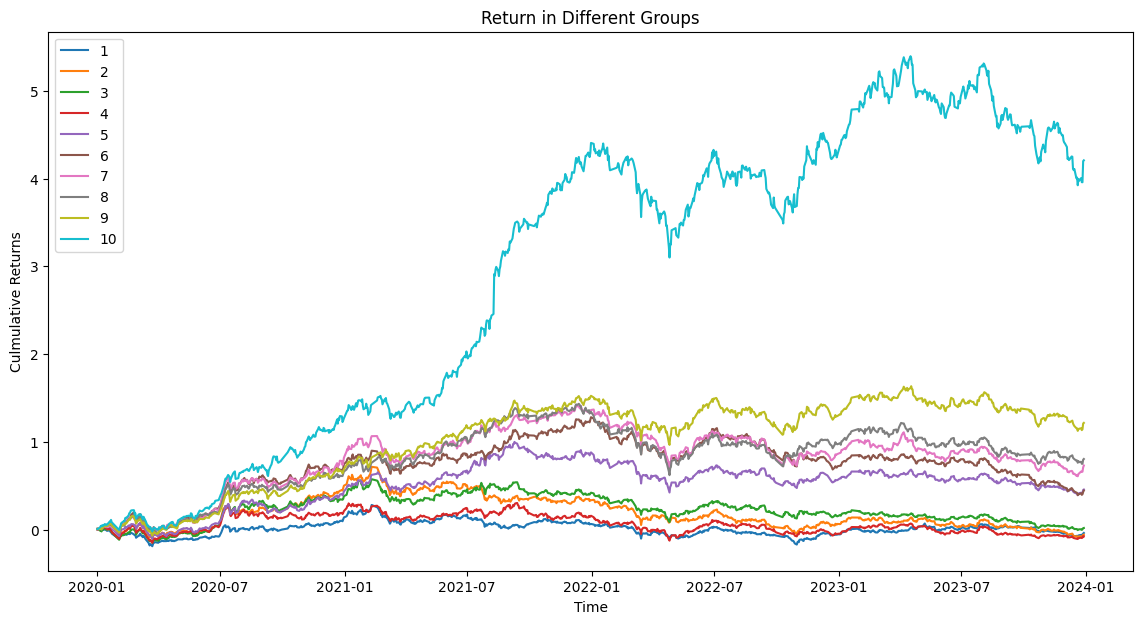

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for group, returns in group_returns_rate.items():
    plt.plot(returns, label=group)

plt.title("Return in Different Groups")
plt.xlabel("Time")
plt.ylabel("Culmulative Returns")
plt.legend()
plt.show()

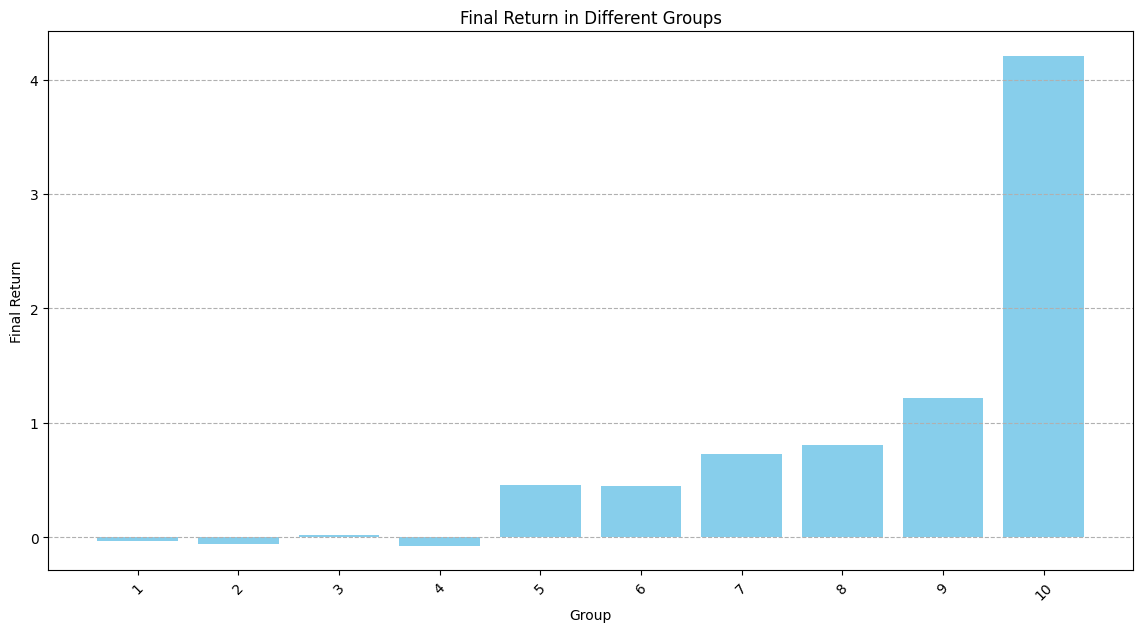

In [15]:
groups_final_returns = {group: returns[-1] for group, returns in group_returns_rate.items()}

plt.figure(figsize=(14, 7))

plt.bar(groups_final_returns.keys(), groups_final_returns.values(), color='skyblue')

plt.title("Final Return in Different Groups")
plt.xlabel("Group")
plt.ylabel("Final Return")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [16]:
import numpy as np
from scipy.stats import t

def t_test_returns(returns):
    # 计算样本均值和标准差
    mean_return = np.mean(returns)
    std_return = np.std(returns, ddof=1)  # ddof=1 让标准差的计算是基于N-1的
    T = len(returns)

    se = std_return / np.sqrt(T)
    t_value = mean_return / se
    p_value = t.sf(np.abs(t_value), df=T-1) * 2

    print(f"Mean return: {mean_return}")
    print(f"Standard error: {se}")
    print(f"T-value: {t_value}")
    print(f"P-value: {p_value}")

    if p_value < 0.05:
        print("在5%的显著性水平下, 我们拒绝原假设。因子的平均收益率显著不为零。")
    else:
        print("在5%的显著性水平下, 我们不能拒绝原假设。")

In [17]:
import numpy as np
from scipy.stats import t

for group, returns in group_returns_rate.items():
    print(f"Group: {group}")
    t_test_returns(group_returns_rate[group])

Group: 1
Mean return: 0.012662319356995641
Standard error: 0.0025091275377759413
T-value: 5.046502884512344
P-value: 5.372229662980419e-07
在5%的显著性水平下, 我们拒绝原假设。因子的平均收益率显著不为零。
Group: 2
Mean return: 0.1901130181627722
Standard error: 0.005827774386006725
T-value: 32.6218905486903
P-value: 4.080552262907908e-158
在5%的显著性水平下, 我们拒绝原假设。因子的平均收益率显著不为零。
Group: 3
Mean return: 0.23019837556956377
Standard error: 0.0051553546698851335
T-value: 44.65228685705397
P-value: 2.1215286912641983e-237
在5%的显著性水平下, 我们拒绝原假设。因子的平均收益率显著不为零。
Group: 4
Mean return: 0.06519244958655832
Standard error: 0.003332942235846722
T-value: 19.560029839519977
P-value: 4.574401027889202e-72
在5%的显著性水平下, 我们拒绝原假设。因子的平均收益率显著不为零。
Group: 5
Mean return: 0.5136632122639553
Standard error: 0.007977550533571838
T-value: 64.38858771277124
P-value: 0.0
在5%的显著性水平下, 我们拒绝原假设。因子的平均收益率显著不为零。
Group: 6
Mean return: 0.7309809795412389
Standard error: 0.009636185806443383
T-value: 75.85791663050512
P-value: 0.0
在5%的显著性水平下, 我们拒绝原假设。因子的平均收益率显著不为零。
G

In [18]:
from scipy.stats import spearmanr

groups_final_returns = {group: returns[-1] for group, returns in groups_returns.items()}
investment_returns = np.array(list(groups_final_returns.values()))

sorting_variable_ranks = np.array(range(1, 11))

# 计算收益率(rank Xr)和排序变量分组(rank Xg)之间的Spearman秩相关系数
rho_s, p_value = spearmanr(investment_returns, sorting_variable_ranks)

# 收益随分组递增-正相关，收益随分组递减-负相关
print("Spearman秩相关系数:", rho_s)
# α>0.05，可以认为没有显著的单调关系
print("p-value:", p_value)

Spearman秩相关系数: 0.9030303030303028
p-value: 0.00034361219776328223
